# 🎭 Facial Emotion Recognition - Model Training

This notebook provides a comprehensive pipeline for training a facial emotion recognition model using the FER2013 dataset.

## Contents:
1. **Setup & Dataset Download** - Install packages and download FER2013
2. **Data Loading & Exploration** - Explore dataset structure
3. **Data Visualization** - Class distribution and sample images
4. **Data Preprocessing** - Augmentation and generators
5. **Model Architecture** - Define CNN model
6. **Training** - Train the model with callbacks
7. **Evaluation** - Analyze model performance
8. **Export** - Save model in multiple formats

---
**Dataset**: FER2013 (48x48 grayscale images, 7 emotion classes)
- Emotions: Angry, Disgust, Fear, Happy, Sad, Surprise, Neutral
- Training samples: ~28,709
- Test samples: ~3,589

## 1. Setup and Dataset Download
Install required packages and download the FER2013 dataset from Kaggle using kagglehub.

In [ ]:
# Install required packages (run once)
# !pip install kagglehub tensorflow opencv-python matplotlib seaborn scikit-learn

In [ ]:
# Import libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Dropout, Flatten,
    BatchNormalization, GlobalAveragePooling2D, Input
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, 
    ReduceLROnPlateau, TensorBoard
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Sklearn for evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Download dataset
import kagglehub

print(f"TensorFlow version: {tf.__version__}")

# GPU Configuration
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth to avoid allocating all GPU memory at once
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU(s) available: {len(gpus)}")
        for i, gpu in enumerate(gpus):
            print(f"   GPU {i}: {gpu.name}")
    except RuntimeError as e:
        print(f"⚠️ GPU configuration error: {e}")
else:
    print("⚠️ No GPU detected. Training will use CPU (slower).")
    print("   For GPU support, install: pip install tensorflow[and-cuda]")

2025-11-30 01:13:58.731490: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.20.0
GPU available: []


W0000 00:00:1764461641.019691  765768 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
# Download FER2013 dataset using kagglehub
dataset_path = kagglehub.dataset_download("msambare/fer2013")
print(f"Dataset downloaded to: {dataset_path}")

# Define paths
TRAIN_DIR = os.path.join(dataset_path, 'train')
TEST_DIR = os.path.join(dataset_path, 'test')

# Create models directory for saving
MODELS_DIR = Path('../models')
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print(f"\nTrain directory: {TRAIN_DIR}")
print(f"Test directory: {TEST_DIR}")
print(f"Models directory: {MODELS_DIR.absolute()}")

100%|██████████| 60.3M/60.3M [01:00<00:00, 1.05MB/s]

Extracting files...


Dataset downloaded to: /home/siaziz/.cache/kagglehub/datasets/msambare/fer2013/versions/1

Train directory: /home/siaziz/.cache/kagglehub/datasets/msambare/fer2013/versions/1/train
Test directory: /home/siaziz/.cache/kagglehub/datasets/msambare/fer2013/versions/1/test
Models directory: /home/siaziz/Desktop/Real-time-Facial-Emotion-Recognition/training/../models


## 2. Data Loading and Exploration
Explore the dataset structure and count images per emotion category.

In [4]:
# Define emotion classes
EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
NUM_CLASSES = len(EMOTIONS)
IMG_SIZE = (48, 48)

# Count images per category
def count_images(directory):
    """Count images in each emotion subdirectory"""
    counts = {}
    for emotion in EMOTIONS:
        emotion_dir = os.path.join(directory, emotion)
        if os.path.exists(emotion_dir):
            counts[emotion] = len([f for f in os.listdir(emotion_dir) 
                                   if f.endswith(('.jpg', '.png', '.jpeg'))])
        else:
            counts[emotion] = 0
    return counts

# Get counts
train_counts = count_images(TRAIN_DIR)
test_counts = count_images(TEST_DIR)

# Create summary DataFrame
summary_df = pd.DataFrame({
    'Emotion': EMOTIONS,
    'Train': [train_counts[e] for e in EMOTIONS],
    'Test': [test_counts[e] for e in EMOTIONS]
})
summary_df['Total'] = summary_df['Train'] + summary_df['Test']
summary_df['Train %'] = (summary_df['Train'] / summary_df['Train'].sum() * 100).round(2)

print("=" * 60)
print("📊 DATASET SUMMARY")
print("=" * 60)
print(f"\n🏋️ Training samples: {summary_df['Train'].sum():,}")
print(f"🧪 Test samples: {summary_df['Test'].sum():,}")
print(f"📁 Total samples: {summary_df['Total'].sum():,}")
print(f"🎯 Number of classes: {NUM_CLASSES}")
print(f"📐 Image size: {IMG_SIZE}")
print("\n" + "=" * 60)
print(summary_df.to_string(index=False))
print("=" * 60)

📊 DATASET SUMMARY

🏋️ Training samples: 28,709
🧪 Test samples: 7,178
📁 Total samples: 35,887
🎯 Number of classes: 7
📐 Image size: (48, 48)

 Emotion  Train  Test  Total  Train %
   angry   3995   958   4953    13.92
 disgust    436   111    547     1.52
    fear   4097  1024   5121    14.27
   happy   7215  1774   8989    25.13
     sad   4830  1247   6077    16.82
surprise   3171   831   4002    11.05
 neutral   4965  1233   6198    17.29


## 3. Data Visualization - Class Distribution
Visualize the distribution of emotion classes in the dataset.

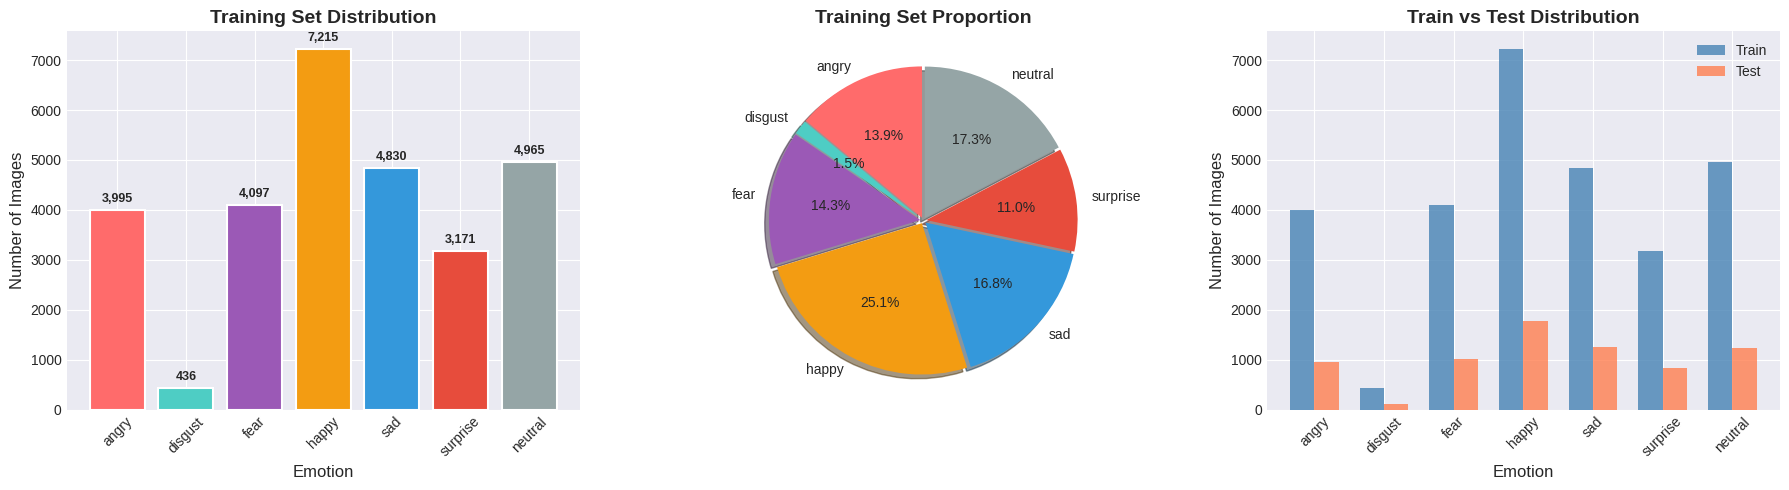


📈 Class distribution chart saved to models/class_distribution.png


In [5]:
# Set style for professional visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Color palette for emotions
emotion_colors = {
    'angry': '#FF6B6B',
    'disgust': '#4ECDC4',
    'fear': '#9B59B6',
    'happy': '#F39C12',
    'sad': '#3498DB',
    'surprise': '#E74C3C',
    'neutral': '#95A5A6'
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Bar chart - Training distribution
colors = [emotion_colors[e] for e in EMOTIONS]
bars = axes[0].bar(EMOTIONS, [train_counts[e] for e in EMOTIONS], color=colors, edgecolor='white', linewidth=1.5)
axes[0].set_title('Training Set Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Emotion', fontsize=12)
axes[0].set_ylabel('Number of Images', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
for bar, count in zip(bars, [train_counts[e] for e in EMOTIONS]):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
                 f'{count:,}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Pie chart - Training distribution
axes[1].pie([train_counts[e] for e in EMOTIONS], labels=EMOTIONS, autopct='%1.1f%%',
            colors=colors, explode=[0.02]*7, shadow=True, startangle=90)
axes[1].set_title('Training Set Proportion', fontsize=14, fontweight='bold')

# Grouped bar chart - Train vs Test
x = np.arange(len(EMOTIONS))
width = 0.35
bars1 = axes[2].bar(x - width/2, [train_counts[e] for e in EMOTIONS], width, label='Train', color='steelblue', alpha=0.8)
bars2 = axes[2].bar(x + width/2, [test_counts[e] for e in EMOTIONS], width, label='Test', color='coral', alpha=0.8)
axes[2].set_title('Train vs Test Distribution', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Emotion', fontsize=12)
axes[2].set_ylabel('Number of Images', fontsize=12)
axes[2].set_xticks(x)
axes[2].set_xticklabels(EMOTIONS, rotation=45)
axes[2].legend()

plt.tight_layout()
plt.savefig('../models/class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📈 Class distribution chart saved to models/class_distribution.png")

## 4. Data Visualization - Sample Images
Display sample images from each emotion category to understand the visual characteristics.

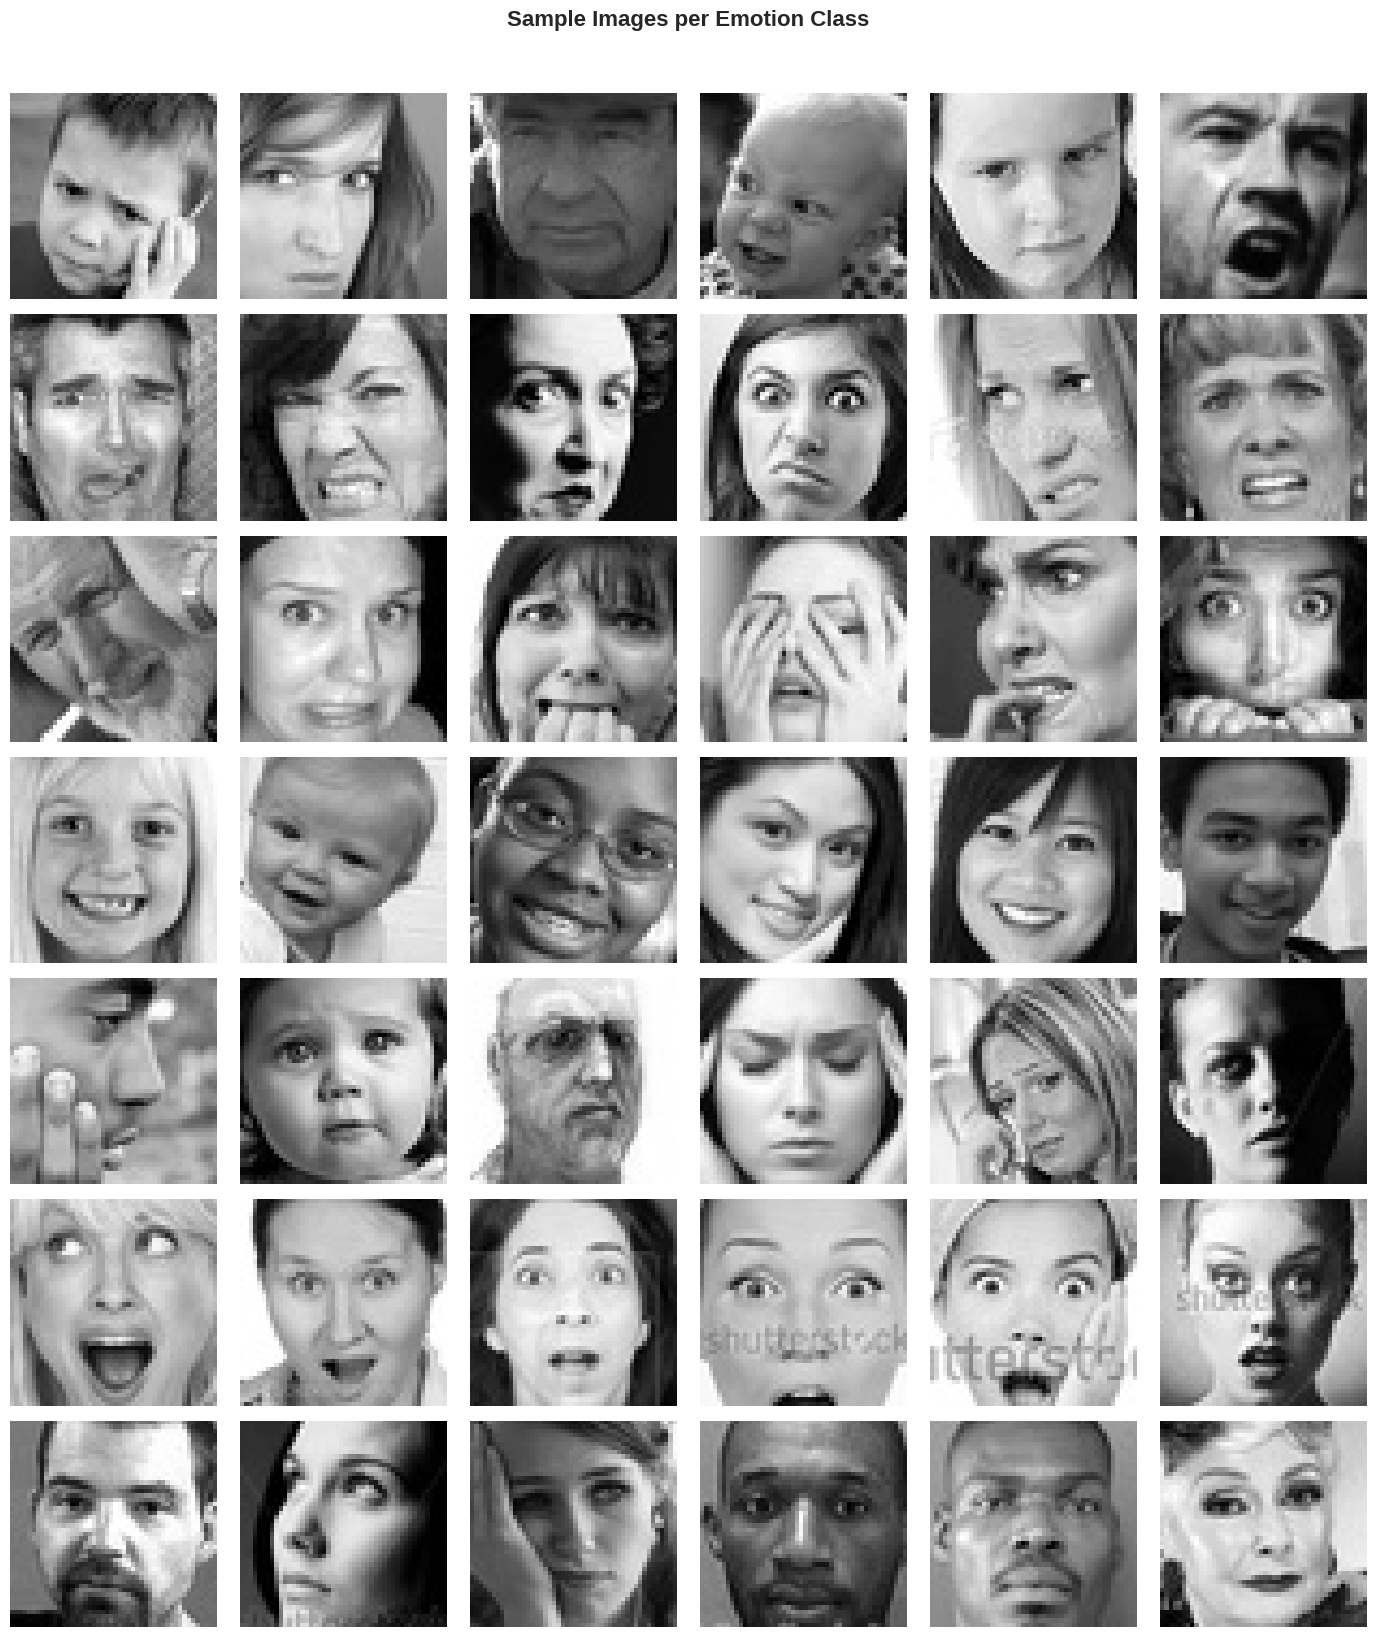


🖼️ Sample images grid saved to models/sample_images.png


In [6]:
import cv2
from PIL import Image

def load_sample_images(directory, emotion, n_samples=5):
    """Load sample images from an emotion directory"""
    emotion_dir = os.path.join(directory, emotion)
    images = []
    if os.path.exists(emotion_dir):
        files = [f for f in os.listdir(emotion_dir) if f.endswith(('.jpg', '.png', '.jpeg'))][:n_samples]
        for f in files:
            img_path = os.path.join(emotion_dir, f)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
    return images

# Create grid of sample images
fig, axes = plt.subplots(7, 6, figsize=(14, 16))
fig.suptitle('Sample Images per Emotion Class', fontsize=16, fontweight='bold', y=1.02)

for i, emotion in enumerate(EMOTIONS):
    samples = load_sample_images(TRAIN_DIR, emotion, n_samples=6)
    
    # Add emotion label on the left
    axes[i, 0].set_ylabel(emotion.upper(), fontsize=12, fontweight='bold', 
                          rotation=0, ha='right', va='center',
                          color=emotion_colors[emotion])
    
    for j, img in enumerate(samples):
        if j < 6:
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
    
    # Fill empty slots
    for j in range(len(samples), 6):
        axes[i, j].axis('off')

plt.tight_layout()
plt.savefig('../models/sample_images.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n🖼️ Sample images grid saved to models/sample_images.png")

## 5. Data Preprocessing and Augmentation
Create data generators with augmentation for training and simple rescaling for validation.

In [7]:
# Configuration
BATCH_SIZE = 64
TARGET_SIZE = IMG_SIZE  # (48, 48)

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation/Test data generator - only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

print("\n✅ Data generators created successfully!")
print(f"📦 Training batches: {len(train_generator)}")
print(f"📦 Validation batches: {len(validation_generator)}")
print(f"🏷️ Class indices: {train_generator.class_indices}")

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.

✅ Data generators created successfully!
📦 Training batches: 449
📦 Validation batches: 113
🏷️ Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Found 7178 images belonging to 7 classes.

✅ Data generators created successfully!
📦 Training batches: 449
📦 Validation batches: 113
🏷️ Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


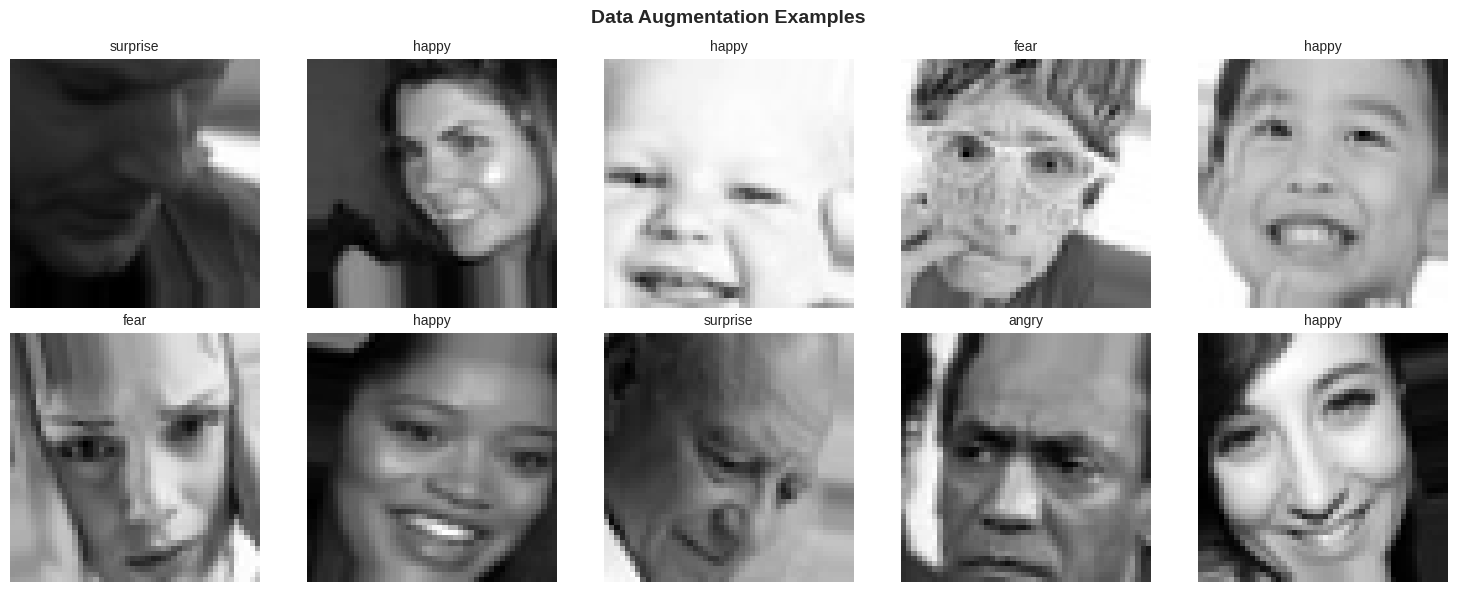

In [8]:
# Visualize augmented images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Data Augmentation Examples', fontsize=14, fontweight='bold')

# Get a batch of images
sample_batch = next(train_generator)
images, labels = sample_batch

for i in range(10):
    row, col = i // 5, i % 5
    axes[row, col].imshow(images[i].squeeze(), cmap='gray')
    emotion_idx = np.argmax(labels[i])
    axes[row, col].set_title(EMOTIONS[emotion_idx], fontsize=10)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Reset generator
train_generator.reset()

## 6. Model Architecture Definition
Define a CNN model with multiple convolutional blocks, batch normalization, and dropout for regularization.

In [9]:
def build_emotion_model(input_shape=(48, 48, 1), num_classes=7):
    """
    Build a CNN model for facial emotion recognition.
    
    Architecture:
    - 4 Convolutional blocks with increasing filters
    - Batch normalization after each conv layer
    - MaxPooling and Dropout for regularization
    - Dense layers with dropout
    """
    model = Sequential([
        # Block 1
        Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Block 2
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Block 3
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Block 4
        Conv2D(512, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(512, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Fully Connected Layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Build model
model = build_emotion_model(input_shape=(48, 48, 1), num_classes=NUM_CLASSES)

# Display model summary
model.summary()

# Visualize model architecture
print("\n📐 Model Architecture Summary:")
print(f"   Total layers: {len(model.layers)}")
print(f"   Total params: {model.count_params():,}")
print(f"   Trainable params: {sum([np.prod(w.shape) for w in model.trainable_weights]):,}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 7,187,911 (27.42 MB)

 Trainable params: 7,182,535 (27.40 MB)

 Non-trainable params: 5,376 (21.00 KB)


📐 Model Architecture Summary:
   Total layers: 32
   Total params: 7,187,911
   Trainable params: 7,182,535


## 7. Model Compilation and Callbacks
Compile the model and set up training callbacks for monitoring and optimization.

In [10]:
# Compile the model
LEARNING_RATE = 0.0001

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Calculate class weights for imbalanced dataset
train_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weight_dict = dict(enumerate(class_weights))

print("📊 Class weights for imbalanced data:")
for idx, emotion in enumerate(EMOTIONS):
    print(f"   {emotion}: {class_weight_dict[idx]:.3f}")

📊 Class weights for imbalanced data:
   angry: 1.027
   disgust: 9.407
   fear: 1.001
   happy: 0.568
   sad: 0.826
   surprise: 0.849
   neutral: 1.293


In [11]:
# Define callbacks
EPOCHS = 50

callbacks = [
    # Save best model
    ModelCheckpoint(
        filepath=str(MODELS_DIR / 'emotion_model_best.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    
    # Early stopping
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate on plateau
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    
    # TensorBoard logging
    TensorBoard(
        log_dir=str(MODELS_DIR / 'logs'),
        histogram_freq=1
    )
]

print("✅ Callbacks configured:")
print("   - ModelCheckpoint: Save best model")
print("   - EarlyStopping: Stop if no improvement for 10 epochs")
print("   - ReduceLROnPlateau: Reduce LR by 0.5 if no improvement for 5 epochs")
print("   - TensorBoard: Training logs")

✅ Callbacks configured:
   - ModelCheckpoint: Save best model
   - EarlyStopping: Stop if no improvement for 10 epochs
   - ReduceLROnPlateau: Reduce LR by 0.5 if no improvement for 5 epochs
   - TensorBoard: Training logs


## 8. Model Training
Train the model with the configured callbacks and class weights.

In [12]:
print("🚀 Starting training...")
print("=" * 60)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

print("=" * 60)
print("✅ Training completed!")

🚀 Starting training...
Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1535 - loss: 3.0408
Epoch 1: val_accuracy improved from None to 0.03107, saving model to ../models/emotion_model_best.keras

Epoch 1: val_accuracy improved from None to 0.03107, saving model to ../models/emotion_model_best.keras


2025-11-30 01:28:26.162453: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 70778880 exceeds 10% of free system memory.
2025-11-30 01:28:26.256356: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 141557760 exceeds 10% of free system memory.
2025-11-30 01:28:26.419174: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 283115520 exceeds 10% of free system memory.
2025-11-30 01:28:26.419174: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 283115520 exceeds 10% of free system memory.
2025-11-30 01:28:26.681854: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 566231040 exceeds 10% of free system memory.
2025-11-30 01:28:26.681854: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 566231040 exceeds 10% of free system memory.
2025-11-30 01:28:27.112685: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:

449/449 ━━━━━━━━━━━━━━━━━━━━ 788s 2s/step - accuracy: 0.1545 - loss: 2.9648 - val_accuracy: 0.0311 - val_loss: 2.3772 - learning_rate: 1.0000e-04
Epoch 2/50
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1640 - loss: 2.6674
Epoch 2: val_accuracy improved from 0.03107 to 0.14976, saving model to ../models/emotion_model_best.keras

Epoch 2: val_accuracy improved from 0.03107 to 0.14976, saving model to ../models/emotion_model_best.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 557s 1s/step - accuracy: 0.1634 - loss: 2.6345 - val_accuracy: 0.1498 - val_loss: 2.0674 - learning_rate: 1.0000e-04
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 557s 1s/step - accuracy: 0.1634 - loss: 2.6345 - val_accuracy: 0.1498 - val_loss: 2.0674 - learning_rate: 1.0000e-04
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1643 - loss: 2.5435
Epoch 3: val_accuracy improved from 0.14976 to 0.20507, saving model to ../models/emotion_model_best.keras

Epoch 3: val_accuracy improved from 0.14976 to 

## 9. Training History Visualization
Plot training and validation accuracy/loss curves to analyze model learning.

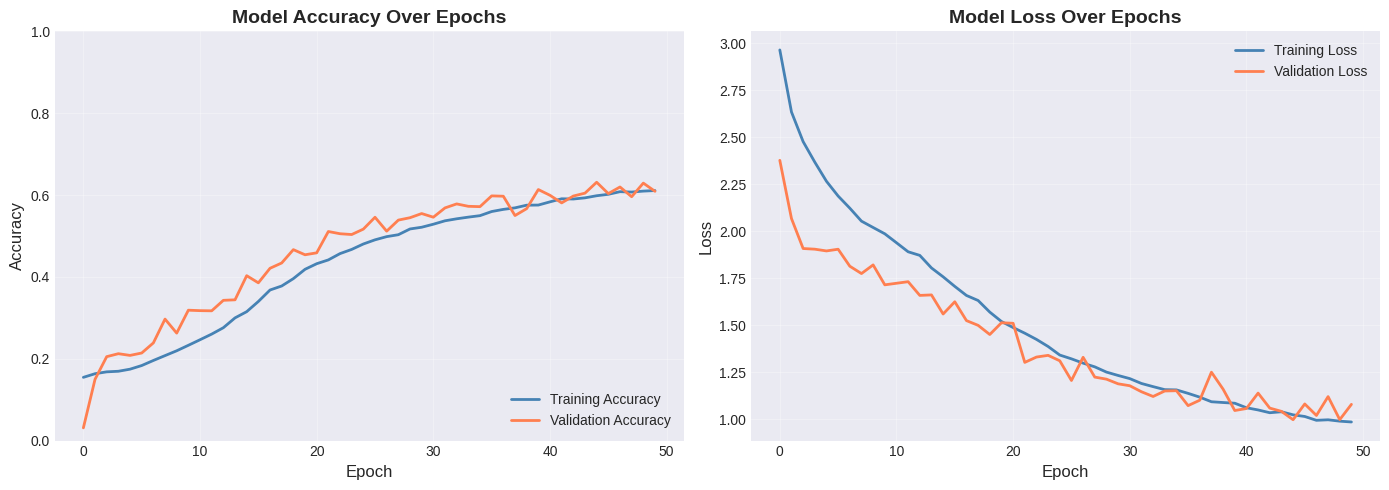


📈 Best validation accuracy: 0.6312 at epoch 45
📉 Final training accuracy: 0.6110
📉 Final validation accuracy: 0.6091


In [13]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='steelblue')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='coral')
axes[0].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2, color='steelblue')
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='coral')
axes[1].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../models/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

# Print best results
best_val_acc = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
print(f"\n📈 Best validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
print(f"📉 Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"📉 Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

## 10. Model Evaluation and Confusion Matrix
Evaluate the model on test data and generate detailed performance metrics.

In [14]:
# Evaluate on test set
print("🧪 Evaluating model on test set...")
validation_generator.reset()
test_loss, test_accuracy = model.evaluate(validation_generator, verbose=1)

print(f"\n📊 Test Results:")
print(f"   Loss: {test_loss:.4f}")
print(f"   Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

🧪 Evaluating model on test set...
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 221ms/step - accuracy: 0.6312 - loss: 0.9967

📊 Test Results:
   Loss: 0.9967
   Accuracy: 0.6312 (63.12%)
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 221ms/step - accuracy: 0.6312 - loss: 0.9967

📊 Test Results:
   Loss: 0.9967
   Accuracy: 0.6312 (63.12%)


113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 226ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 226ms/step

📋 Classification Report:
              precision    recall  f1-score   support

       angry       0.54      0.57      0.55       958
     disgust       0.39      0.76      0.51       111
        fear       0.54      0.32      0.40      1024
       happy       0.88      0.82      0.85      1774
         sad       0.52      0.70      0.60      1233
    surprise       0.57      0.45      0.50      1247
     neutral       0.67      0.85      0.75       831

    accuracy                           0.63      7178
   macro avg       0.59      0.64      0.59      7178
weighted avg       0.64      0.63      0.62      7178


📋 Classification Report:
              precision    recall  f1-score   support

       angry       0.54      0.57      0.55       958
     disgust       0.39      0.76      0.51       111
        fear       0.54      0.32      0.40      1024
       happy       0.88      0.82      0.85   

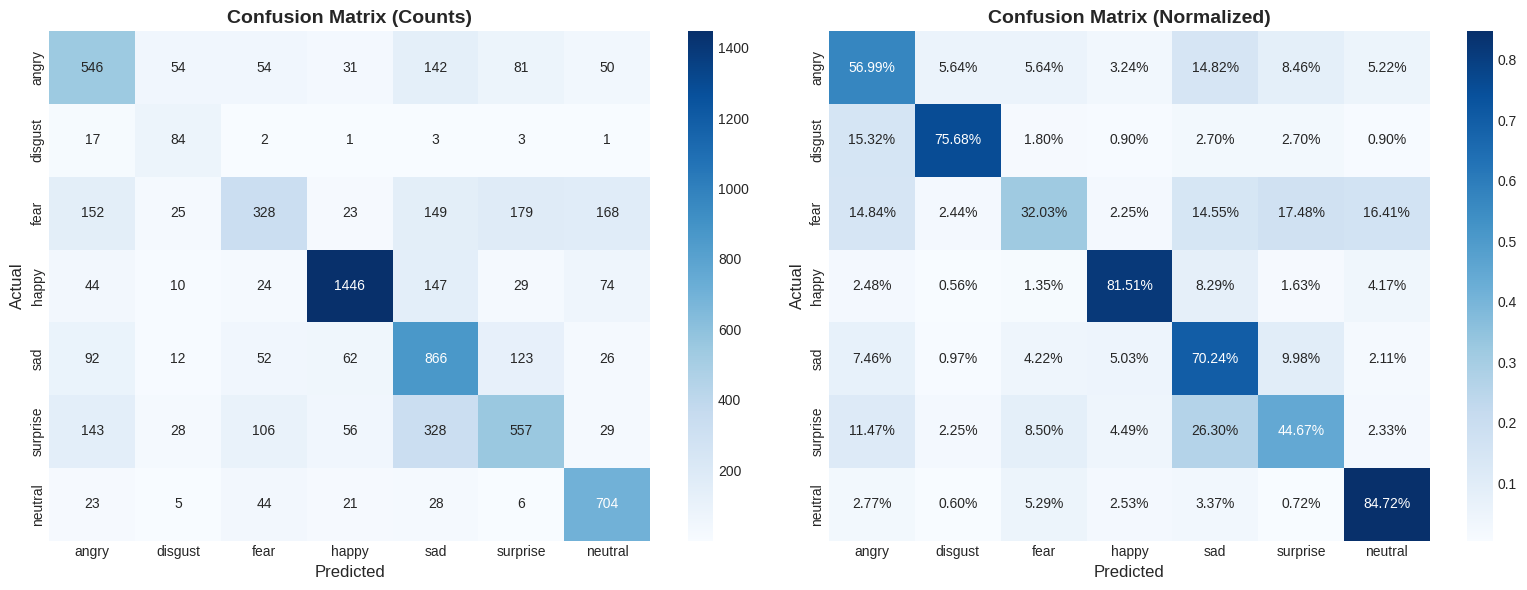


📊 Confusion matrix saved to models/confusion_matrix.png


In [15]:
# Generate predictions
validation_generator.reset()
predictions = model.predict(validation_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes

# Classification report
print("\n📋 Classification Report:")
print("=" * 60)
print(classification_report(true_classes, predicted_classes, target_names=EMOTIONS))

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=EMOTIONS, yticklabels=EMOTIONS, ax=axes[0])
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)

# Normalized
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=EMOTIONS, yticklabels=EMOTIONS, ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)

plt.tight_layout()
plt.savefig('../models/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Confusion matrix saved to models/confusion_matrix.png")

## 11. Model Export and Saving
Save the trained model in multiple formats for deployment.

In [17]:
# Save model in different formats
print("💾 Saving model in multiple formats...")

# 1. Keras native format (recommended)
keras_path = MODELS_DIR / 'emotion_model.keras'
model.save(keras_path)
print(f"   ✅ Keras format: {keras_path}")

# 2. H5 format (legacy, for compatibility)
h5_path = MODELS_DIR / 'emotion_model.h5'
model.save(h5_path)
print(f"   ✅ H5 format: {h5_path}")

# 3. SavedModel format (for TensorFlow Serving) - use export() method
savedmodel_path = MODELS_DIR / 'emotion_model_savedmodel'
try:
    model.export(str(savedmodel_path))
    print(f"   ✅ SavedModel format: {savedmodel_path}")
except Exception as e:
    print(f"   ⚠️ SavedModel export skipped: {e}")

# 4. Save model architecture to JSON
architecture_path = MODELS_DIR / 'model_architecture.json'
with open(architecture_path, 'w') as f:
    f.write(model.to_json())
print(f"   ✅ Architecture JSON: {architecture_path}")

# 5. Save training history
history_df = pd.DataFrame(history.history)
history_path = MODELS_DIR / 'training_history.csv'
history_df.to_csv(history_path, index=False)
print(f"   ✅ Training history: {history_path}")

# 6. Save model summary to text file
summary_path = MODELS_DIR / 'model_summary.txt'
with open(summary_path, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    f.write(f"\n{'='*60}\n")
    f.write(f"Final Test Accuracy: {test_accuracy:.4f}\n")
    f.write(f"Final Test Loss: {test_loss:.4f}\n")
    f.write(f"Best Validation Accuracy: {best_val_acc:.4f} at epoch {best_epoch}\n")
print(f"   ✅ Model summary: {summary_path}")

print("\n🎉 All models and artifacts saved successfully!")
print(f"📁 Models directory: {MODELS_DIR.absolute()}")

💾 Saving model in multiple formats...


   ✅ Keras format: ../models/emotion_model.keras
   ✅ H5 format: ../models/emotion_model.h5
   ✅ H5 format: ../models/emotion_model.h5
INFO:tensorflow:Assets written to: ../models/emotion_model_savedmodel/assets
INFO:tensorflow:Assets written to: ../models/emotion_model_savedmodel/assets


INFO:tensorflow:Assets written to: ../models/emotion_model_savedmodel/assets


Saved artifact at '../models/emotion_model_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  131896397908304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131896397911952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131896397910416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131896397907728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131896397916176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131896397916368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131896397915024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131896397915216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131896397909456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131896397916944: TensorSpec(shape=(), dtype=tf.resource, name=None)


   ✅ Model summary: ../models/model_summary.txt

🎉 All models and artifacts saved successfully!
📁 Models directory: /home/siaziz/Desktop/Real-time-Facial-Emotion-Recognition/training/../models


In [18]:
# Final summary
print("\n" + "=" * 60)
print("🏆 TRAINING COMPLETE - SUMMARY")
print("=" * 60)
print(f"""
📊 Dataset:
   - Training samples: {train_generator.samples:,}
   - Test samples: {validation_generator.samples:,}
   - Classes: {NUM_CLASSES} emotions

🧠 Model:
   - Architecture: Custom CNN (4 conv blocks)
   - Total parameters: {model.count_params():,}
   - Input shape: {IMG_SIZE} grayscale

📈 Performance:
   - Best validation accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)
   - Test accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)
   - Test loss: {test_loss:.4f}

💾 Saved Files:
   - emotion_model.keras (recommended)
   - emotion_model.h5 (legacy)
   - emotion_model_savedmodel/ (TF Serving)
   - model_architecture.json
   - training_history.csv
   - confusion_matrix.png
   - training_history.png

🚀 Next Steps:
   1. Run main.py to start real-time emotion detection
   2. The model will be loaded from models/emotion_model.keras
""")
print("=" * 60)


🏆 TRAINING COMPLETE - SUMMARY

📊 Dataset:
   - Training samples: 28,709
   - Test samples: 7,178
   - Classes: 7 emotions

🧠 Model:
   - Architecture: Custom CNN (4 conv blocks)
   - Total parameters: 7,187,911
   - Input shape: (48, 48) grayscale

📈 Performance:
   - Best validation accuracy: 0.6312 (63.12%)
   - Test accuracy: 0.6312 (63.12%)
   - Test loss: 0.9967

💾 Saved Files:
   - emotion_model.keras (recommended)
   - emotion_model.h5 (legacy)
   - emotion_model_savedmodel/ (TF Serving)
   - model_architecture.json
   - training_history.csv
   - confusion_matrix.png
   - training_history.png

🚀 Next Steps:
   1. Run main.py to start real-time emotion detection
   2. The model will be loaded from models/emotion_model.keras

